# 1. Kütüphaneler ve Test Verisinin Hazırlanması

Bu bölümde, test işlemleri için gerekli kütüphaneleri yüklüyoruz ve daha önce oluşturduğumuz `Veri_Düzenleme` modülünü kullanarak sadece **Test** veri setini çağırıyoruz.

* **Not:** Eğitim verisine bu aşamada ihtiyacımız yoktur.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm 

# --- Veri Fabrikasını Çağırma ---
%run FET312_22040301043_DevTeam177_1.ipynb
print("Veri düzenleme modülü başarıyla yüklendi.")
_, _, test_loader, NUM_CLASSES = get_data_loaders(batch_size=64, num_workers=0)

if test_loader is None:
    raise RuntimeError("Test verisi yüklenemedi. Lütfen Veri_Düzenleme dosyasını kontrol edin.")
    
print(f"Test verisi hazır. Toplam {NUM_CLASSES} sınıf üzerinde test yapılacak.")

--- Veri_Duzenleme.ipynb Test Modunda Çalıştırılıyor ---
Eğitim verisi yüklendi. Toplam 43 sınıf bulundu.
Train/Validation ayrımı yapıldı: 31367 Train, 7842 Validation
Test verisi yüklendi. Boyut: 12630
DataLoaders (train, val, test) başarıyla oluşturuldu.

Test başarılı. Sınıf sayısı: 43
Train loader'da 491 batch var.
Val loader'da 123 batch var.
Test loader'da 198 batch var.
İlk train batch boyutu (Resimler): torch.Size([64, 3, 64, 64])
İlk train batch boyutu (Etiketler): torch.Size([64])
Veri düzenleme modülü başarıyla yüklendi.
Eğitim verisi yüklendi. Toplam 43 sınıf bulundu.
Train/Validation ayrımı yapıldı: 31367 Train, 7842 Validation
Test verisi yüklendi. Boyut: 12630
DataLoaders (train, val, test) başarıyla oluşturuldu.
Test verisi hazır. Toplam 43 sınıf üzerinde test yapılacak.


# 2. Model Mimarisinin Tanımlanması

PyTorch'ta eğitilmiş ağırlıkları (`.pth` dosyası) yükleyebilmek için, modelin mimarisini (iskeletini) kodun içinde tekrar tanımlamamız gerekir. Bu yapı, eğitim dosyasındaki ile **birebir aynı** olmalıdır.

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # 1. Evrişim Bloğu
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 2. Evrişim Bloğu
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        # Tam Bağlantılı Katmanlar
        self.fc1 = nn.Linear(in_features=32 * 16 * 16, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print("Model mimarisi tanımlandı.")

Model mimarisi tanımlandı.


# 3. Eğitilmiş Model Ağırlıklarının Yüklenmesi

Bu adımda:
1.  Modeli oluşturup uygun cihaza (GPU/CPU) gönderiyoruz.
2.  Eğitim aşamasında kaydettiğimiz `SimpleCNN_model.pth` dosyasını yüklüyoruz.
3.  `load_state_dict` fonksiyonu ile kaydedilen ağırlıkları boş modele aktarıyoruz.

In [6]:
# Cihaz seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Test işleminin yapılacağı cihaz: {device}")

# Modeli oluştur
model = SimpleCNN(num_classes=NUM_CLASSES).to(device)

# Ağırlıkları yükle
MODEL_PATH = 'SimpleCNN_model.pth'

try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
    print(f"BAŞARILI: '{MODEL_PATH}' dosyasından model ağırlıkları yüklendi.")
except FileNotFoundError:
    print(f"HATA: '{MODEL_PATH}' dosyası bulunamadı.")
    print("Lütfen önce 'SimpleCNN_Egitim.ipynb' dosyasını çalıştırıp modeli eğitin.")
    raise
except Exception as e:
    print(f"Model yüklenirken hata oluştu: {e}")
    raise

Test işleminin yapılacağı cihaz: cpu
BAŞARILI: 'SimpleCNN_model.pth' dosyasından model ağırlıkları yüklendi.


# 4. Modelin Test Seti Üzerinde Değerlendirilmesi

Modeli `eval()` moduna alarak (ağırlıkları dondurarak) test veri setindeki tüm görüntüler üzerinde tahmin yapıyoruz. Gerçek etiketleri ve modelin tahminlerini listelerde topluyoruz.

In [7]:
print("Test işlemi başlıyor...")
model.eval() # Değerlendirme modu

all_labels = []
all_predictions = []

# İlerleme çubuğu
test_progress = tqdm(test_loader, desc="[Test]", leave=False)

with torch.no_grad(): # Gradyan hesaplamayı kapat (Hız ve hafıza için)
    for images, labels in test_progress:
        # Bozuk verileri atla (Veri_Düzenleme'den None gelebilir)
        if images is None:
            continue
            
        images = images.to(device)
        labels = labels.to(device)
        
        # Tahmin yap
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Sonuçları listeye ekle (CPU'ya alarak)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print("Test işlemi tamamlandı.")

Test işlemi başlıyor...


Test işlemi tamamlandı.


# 5. Performans Metrikleri ve Görselleştirme

Hocanın proje isterlerinde belirttiği metrikleri hesaplıyoruz:
1.  **Accuracy (Doğruluk):** Genel başarı oranı.
2.  **Classification Report:** Her sınıf için Precision, Recall ve F1-Score değerleri.
3.  **Confusion Matrix:** Modelin hangi sınıfları birbiriyle karıştırdığını gösteren ısı haritası.


--- TEST SONUÇLARI (SimpleCNN) ---
Genel Doğruluk (Accuracy): %92.86

--- Sınıflandırma Raporu (Precision, Recall, F1-Score) ---
              precision    recall  f1-score   support

           0       0.91      0.67      0.77        60
           1       0.90      0.96      0.93       720
           2       0.88      0.97      0.92       750
           3       0.94      0.93      0.93       450
           4       0.94      0.93      0.94       660
           5       0.90      0.89      0.89       630
           6       0.95      0.74      0.83       150
           7       0.93      0.88      0.91       450
           8       0.92      0.91      0.92       450
           9       0.96      0.96      0.96       480
          10       0.98      0.98      0.98       660
          11       0.94      0.95      0.95       420
          12       0.99      0.97      0.98       690
          13       0.99      1.00      0.99       720
          14       1.00      0.97      0.99       270
     

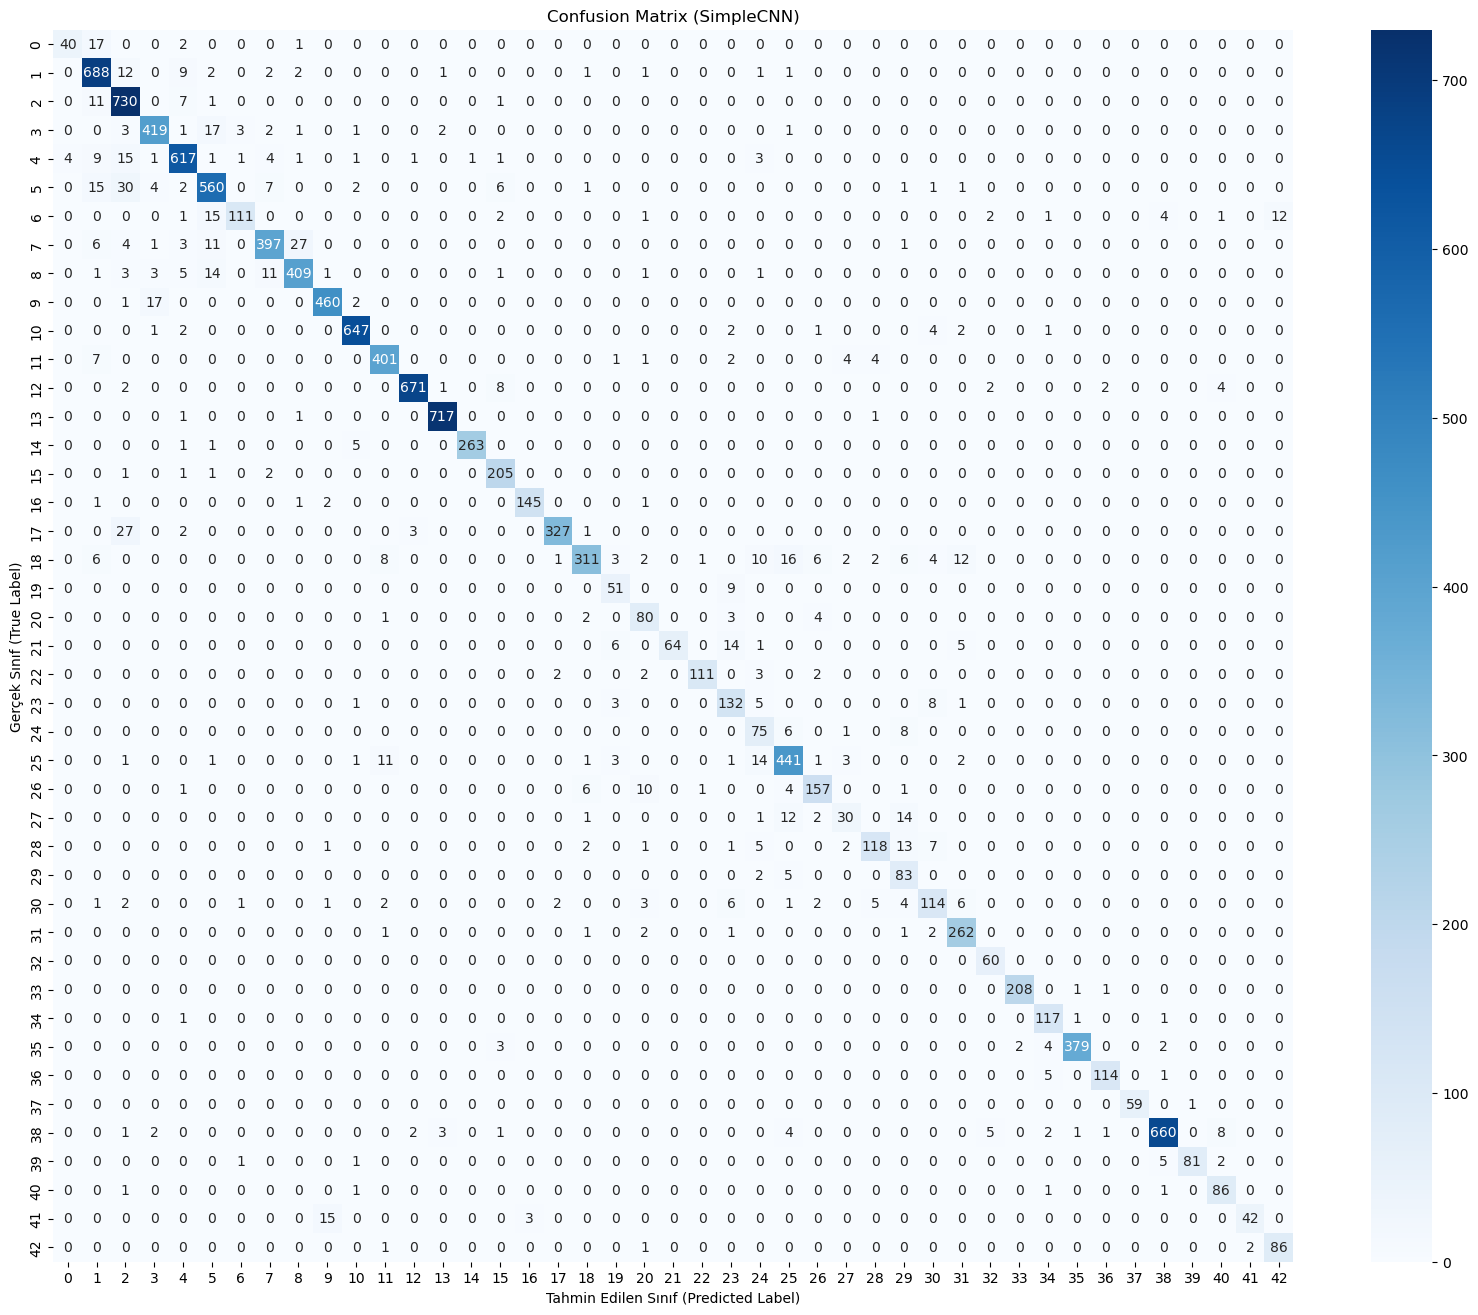

Confusion Matrix 'SimpleCNN_Confusion_Matrix.png' olarak kaydedildi.


In [8]:
# --- Sonuçların Hesaplanması ---

print(f"\n--- TEST SONUÇLARI (SimpleCNN) ---")

# 1. Genel Doğruluk
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Genel Doğruluk (Accuracy): %{accuracy * 100:.2f}")

# 2. Detaylı Rapor
print("\n--- Sınıflandırma Raporu (Precision, Recall, F1-Score) ---")
# zero_division=0 uyarısı, test setinde hiç örneği olmayan sınıflar varsa hata vermemesi içindir
print(classification_report(all_labels, all_predictions, zero_division=0))

# 3. Karmaşıklık Matrisi (Confusion Matrix)
print("\n--- Confusion Matrix Oluşturuluyor ---")
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (SimpleCNN)')
plt.ylabel('Gerçek Sınıf (True Label)')
plt.xlabel('Tahmin Edilen Sınıf (Predicted Label)')

# Grafiği kaydet ve göster
plt.savefig('SimpleCNN_Confusion_Matrix.png')
plt.show()

print("Confusion Matrix 'SimpleCNN_Confusion_Matrix.png' olarak kaydedildi.")